## Task 0
Here I'm generating the encodings for `k=2` for the graph generated by $\mathbb{Z}^1$

The problem can be represented using only the variables `X(i, c)` which means node `i` is assigned the color `c`.
We have the follow constraints:
* Every node has exactly one color
\begin{align*}
    \bigwedge_i \bigvee_c X(i, c) \land \bigwedge_i \bigwedge_{c_1 \neq c_2} \neg X(i, c_1) \lor \neg X(i, c_2)
\end{align*}
* If nodes $i_1$, $i_2$ both have color $c$, they're atleast $c$ distance apart.
\begin{align*}
    \bigwedge_c \bigwedge_{u, v, d(u, v) \leq c} \neg X(u, c) \lor \neg X(v, c)
\end{align*}

In [1]:
from pysat.formula import CNF
from itertools import combinations
import math

We need to denote each $X(i, c)$ as an integer (as cnf files represent boolean
variables as integers). This can be done using
\begin{align*}
    X(i, c) \equiv i * k + c + 1
\end{align*}
where $k$ is the number of colors we have


In [6]:
def var(i, c, k):
    return i * k + c

def get_cnf(n: int, k: int) -> CNF:
    """
    n: number of nodes in graph
    k: number of colors
    """

    cnf = CNF()
    for i in range(n):
        cnf.append([var(i, c, k) for c in range(1, k + 1)])

    for i in range(n):
        for c0, c1 in combinations(range(1, k + 1), 2):
            cnf.append([-var(i, c0, k), -var(i, c1, k)])
    

    for c in range(0, k + 1):
        for i in range(n):
            for j in range(i, min(i + c + 1, n)):
                if i == j: continue
                cnf.append([-var(i, c, k), -var(j, c, k)])
    
    return cnf

In [7]:
n = 60
k = 3
cnf = get_cnf(n, k)
cnf.to_file("Z1.cnf")

## Is it working?

You can run this by changing values of `n` and `k`. The code below can even be run from a seperate file as it just operates on `Z1.cnf` file produced by the encoding we made above. For now, I've hardcoded this to use `z3` and extract the results. And show the colors assigned to each real number

* n: Number of points we're considering to find a coloring. We'll choose the points [0, ..., n - 1] (position doesn't really matter).
* k: Number of colors we're taking

In [8]:
def get_results(n, k, **kwargs):

    file = "Z1.cnf"
    if "file" not in kwargs:
        cnf = get_cnf(n, k)
        cnf.to_file("Z1.cnf")
    else:
        file = kwargs["file"]

    import subprocess

    def unvar(var, k):
        var = var - 1
        return (var // k, var % k + 1)

    def get_colors(arr, k):
        colors = []
        for i in arr:
            if i <= 0: continue
            colors.append(unvar(i, k)[1])
        return colors

    result = subprocess.run(["kissat", file, "Z1-proof.drat"], capture_output=True, text=True)

    if (result.stdout.splitlines()[0] == "s UNSATISFIABLE"):
        print("UNSATISFIABLE")

    else:
        result = result.stdout.splitlines()[1]

        result = list(map(int, result.split()[1:-1]))
        print(f"Colors: {get_colors(result, k)}")

In [9]:
get_results(10, 2)

Colors: []


## Task 1

This was kind of hardcoded for $\mathbb{Z}^1$. Let's try for $\mathbb{Z}^2$ now. We'll represent
\begin{align*}
    X(i, j, c, k) \equiv (i, j) \text{ got color } c \in \{1, \dots, k\} \\
\end{align*}

Now, as given in the paper, to prove $\chi_\rho(\mathbb{Z}^2) \geq k + 1$, we can just prove $D_{r, k, c}$ is unsat for some $r$, $c \leq k$.
So, I'll just encode $D(r, k, c)$ given $r$, $k$, $c$. We can enumerate $\mathbb{Z}^2$ in the same way as we did while proving $\mathbb{Z}^2$ is countable.

Consider an $l_1$ circle of radius $k$ centered (which is locus of points at an $l_1$/Manhattan distance of $r$ from origin, basically a square). With some observation, one can deduce that this has $4k$ integral points. So $(i, j)$ has index $2(|i| + |j|)(|i| + |j| - 1) + 1 + \eta$, where
\begin{align*}
    \eta =
    \begin{cases}
        j + 1, \text{ if } i \geq 0, j \geq 0\\
        2k + 1 - j, \text{ if } i < 0 \\
        4k + 1 + j, \text{ if } i \geq 0, j < 0
    \end{cases}
\end{align*}

Intuitively, $\eta$ is indexing the angle $(i, j)$ is making with positive x-axis.

So, $X(i, j, c, k) = (2(|i| + |j|)(|i| + |j| - 1) + 1 + \eta) * k + c$

In [10]:
def node_index(i, j):
    res = 2 * (abs(i) + abs(j)) * (abs(i) + abs(j) - 1)
    r = abs(i) + abs(j) - 1
    eta = 0
    if i >= 0 and j >= 0:
        eta = j + 1
    elif i < 0:
        eta = 2 * r + 1 - j
    else:
        eta = 4 * r + 1 + j
    res += eta
    return res + 1

def get_ij(node):
    if node == 1:
        return (0, 0)

    node -= 1
    # Have to find r such that 2r(r + 1) < node <= 2(r + 1)(r + 2)
    if node <= 4:
        return get_ij_from_residual(1, node)

    r = (-1 + math.sqrt(1 + 2 * node)) // 2
    while (2 * r * (r + 1) < node):
        r += 1
    r = int(r)

    residual = node - 2 * r * (r - 1)
    return get_ij_from_residual(r, residual)

def get_ij_from_residual(r, residual):
    """
    Basically that eta
    """
    if residual <= r:
        return (r - residual + 1, residual - 1)
    elif residual > r and residual <= 2 * r:
        residual -= r
        return (-residual + 1, r - residual + 1)
    elif residual > 2 * r and residual <= 3 * r:
        residual -= 2 * r
        return (-r + residual - 1, -residual + 1)
    else:
        residual -= 3 * r
        return (residual - 1, residual - r - 1)

def dist(node1, node2):
    i1, j1 = get_ij(node1)
    i2, j2 = get_ij(node2)
    return abs(i1 - i2) + abs(j1 - j2)  # l1 (Manhattan) Distance

def get_cnf2(r, k, c):
    """
    r: radius of the l1 circle being considered.
    k: number of colors we have
    c: color of (0, 0)
    Return: CNF formula of D_{r, k, c} which is true iff there's a valid packing
    for the circle with k colors with (0, 0) being of color c
    """

    cnf = CNF()

    # Every node has atleast one color
    for node in range(1, 2 * r * (r + 1) + 2):
        cnf.append([var(node, c1, k) for c1 in range(1, k + 1)])
    
    # A node can't have two colors simultaneously
    for node in range(1, 2 * r * (r + 1) + 2):
        for c0, c1 in combinations(range(1, k + 1), 2):
            cnf.append([-var(node, c0, k), -var(node, c1, k)])
    
    # If two nodes have distance d, both can't have same color <= d
    for node1 in range(1, 2 * r * (r + 1) + 2):
        for node2 in range(1, 2 * r * (r + 1) + 2):
            if node1 == node2: continue
            for c1 in range(dist(node1, node2), k + 1):
               cnf.append([-var(node1, c1, k), -var(node2, c1, k)])
    
    cnf.append([var(0, c, k)])
    
    return cnf

### Helper function for plotting

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def plot_colored_grid(data):
    """
    data: List of (i, j, c) tuples where (i, j) is grid position in (x, y) format and c is the color ID.
    """
    if not data:
        print("No data to plot!")
        return
    
    # Get coordinate limits
    min_x = min(i for i, _, _ in data)
    max_x = max(i for i, _, _ in data)
    min_y = min(j for _, j, _ in data)
    max_y = max(j for _, j, _ in data)
    
    fig, ax = plt.subplots()
    
    # Create color map (each c gets a unique color)
    unique_colors = list(set(c for _, _, c in data))
    cmap = plt.get_cmap("tab10", len(unique_colors))
    
    # Plot each cell
    for x, y, c in data:
        ax.add_patch(plt.Rectangle((x, y), 1, 1, color=cmap(unique_colors.index(c)), ec='black'))
        ax.text(x + 0.5, y + 0.5, str(c), ha='center', va='center', color='white', fontsize=6, weight='bold')
    
    # Set axis limits and properties to match the xy-plane
    ax.set_xticks(range(min_x, max_x + 2))
    ax.set_yticks(range(min_y, max_y + 2))
    ax.set_xlim(min_x, max_x + 1)
    ax.set_ylim(min_y, max_y + 1)
    ax.set_aspect('equal')
    ax.grid(True, which='both', linestyle='-', linewidth=1)
    plt.xticks(range(min_x, max_x + 2))
    plt.yticks(range(min_y, max_y + 2))
    
    plt.show()


### Generating the CNF file

Just for context. The below cnf is true iff we can color an $l_1$ circle on $\mathbb{Z}^2$ plane using $k$ colors such that origin gets the color $c$.

The reason we're doing is because of this lemma:

Given $\chi_\rho(\mathbb{Z}^2) \geq k$, if there are $r$, $c$ such that $D_{r, k, c}$ is UNSAT then $\chi_\rho(\mathbb{Z}^2) \geq k + 1$

In [33]:
r, k, c = 6, 11, 6
cnf = get_cnf2(r, k, c)
cnf.to_file("Z2.cnf")

### Running the CNF file and making observations

This can be done seperately on your machine also once you've generated the `.cnf` file. Just follow your SAT solver's instructions. For kissat it is `kissat Z2.cnf Z2-proof.drat`. The proof can then be verified using a tool like `drat-trim` using `drat-trim Z2.cnf Z2-proof.drat`

The code below runs the SAT solver. If it's SAT, which means we have a coloring, so it also produces the coloring. If it's UNSAT, there's no coloring. We need to generate proofs that $D_{r, k, c}$ is UNSAT till $k \leq 15$ where $k$ is the allowed number of colors.

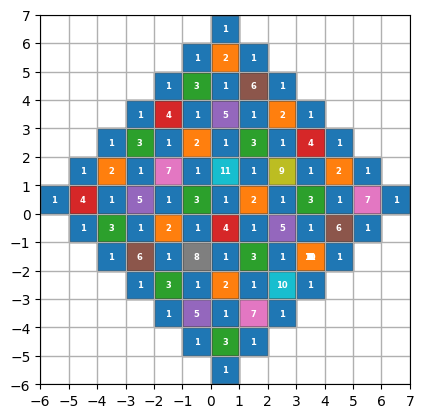

In [34]:
import subprocess

def get_node_color(var, k):
    var = var - 1
    node_idx, color = var // k, var % k
    color += 1
    a, b = get_ij(node_idx)
    return (a, b, color)

result = subprocess.run(["kissat", "Z2.cnf", "Z2-proof.drat"], capture_output=True, text=True)

arr = []
for line in result.stdout.splitlines():
    if line[0] != 'v':
        continue
    arr.extend(list(map(int, line.split()[1:])))

arr = arr[:-1]
data = []
for elem in arr:
    if elem <= 0:
        continue
    i, j, color = get_node_color(elem, k)
    if dist(1, node_index(i, j)) > r:
        continue

    data.append(get_node_color(elem, k))
plot_colored_grid(data)